<a href="https://colab.research.google.com/github/seoyeon2200/25-1_Network-Security/blob/main/Network_Security_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2025-1 Network Security (01)
##Homework #2: ML-Based Network Intrusion Detection System

- Lee Seoyeon(2271045)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Code

### Part 1: 데이터 로딩 및 전처리

In [ ]:
import pandas as pd

# 데이터 로딩 함수
def load_dataset(file_path):
    col_names = ['SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'Protocol', 'PacketSize', 'Timestamp']
    df = pd.read_csv(file_path, header=None, names=col_names)
    df['Timestamp'] = df['Timestamp'].astype(float)
    return df

# 예시: UNSW 데이터 로드
unsw_df = load_dataset('unsw_60_sec_new.csv')
print(unsw_df.head())

        SrcIP       DstIP  SrcPort  DstPort  Protocol  PacketSize  \
0  3232261166  3232261125     3456       80        17         509   
1  3232261175  3232261123     8080       80         6         610   
2  3232261166  3232261125       80       80        17         759   
3  3232261123  3232261175       80     8080         6         685   
4  3232261125  3232261166       80     3456        17         595   

      Timestamp  
0  1.528081e+09  
1  1.528081e+09  
2  1.528081e+09  
3  1.528081e+09  
4  1.528081e+09  


###Part 2: Flow 구성 (5-Tuple 기준 그룹화)


In [ ]:
# 5-Tuple 기준으로 Flow 그룹화
def group_by_flow(df):
    return df.groupby(['SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'Protocol'])


###Part 3: Flow-Level Feature 추출

In [ ]:
import numpy as np
from scipy.stats import entropy

# 단일 flow에서 특징 추출
def extract_features_from_flow(flow):
    packet_sizes = flow['PacketSize'].values
    timestamps = flow['Timestamp'].values
    iats = np.diff(timestamps) if len(timestamps) > 1 else [0]

    features = {
        'FlowSize': len(flow),
        'FlowDuration': timestamps[-1] - timestamps[0] if len(timestamps) > 1 else 0,
        'PktSizeMean': np.mean(packet_sizes),
        'PktSizeMin': np.min(packet_sizes),
        'PktSizeMax': np.max(packet_sizes),
        'PktSizeStd': np.std(packet_sizes),
        'IATMean': np.mean(iats),
        'IATMin': np.min(iats),
        'IATMax': np.max(iats),
        'IATStd': np.std(iats),
        'PktSizeEntropy': entropy(np.unique(packet_sizes, return_counts=True)[1], base=2),
        'IATEntropy': entropy(np.unique(iats, return_counts=True)[1], base=2),
        'PacketRate': len(flow) / (timestamps[-1] - timestamps[0] + 1e-6)
    }
    return features

# 전체 flow에 대해 특징 추출
def extract_all_features(df, label):
    features = []
    for _, flow in group_by_flow(df):
        f = extract_features_from_flow(flow)
        f['Label'] = label
        features.append(f)
    return pd.DataFrame(features)


###Part 4: 전체 데이터 병합 및 학습/테스트 셋 분할

In [ ]:
# 각각의 데이터셋에서 특징 추출 후 병합
caida_df = load_dataset('caida_60_sec_new.csv')
cic_df = load_dataset('cic_60_sec_new.csv')

# 특징 추출 (Label: 0=Benign, 1=Malicious)
caida_features = extract_all_features(caida_df, label=0)
unsw_features = extract_all_features(unsw_df, label=1)
cic_features = extract_all_features(cic_df, label=1)

# 병합
full_data = pd.concat([caida_features, unsw_features, cic_features], ignore_index=True)

# X, y 분리
X = full_data.drop(columns=['Label'])
y = full_data['Label']


###Part 5: 머신러닝 모델 학습 및 평가

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 결과 출력
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19714
           1       1.00      1.00      1.00     39243

    accuracy                           1.00     58957
   macro avg       1.00      1.00      1.00     58957
weighted avg       1.00      1.00      1.00     58957

ROC-AUC Score: 0.9994


###Part 6: 시각화


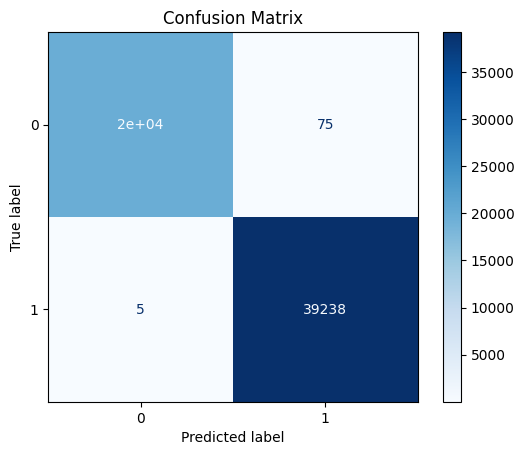

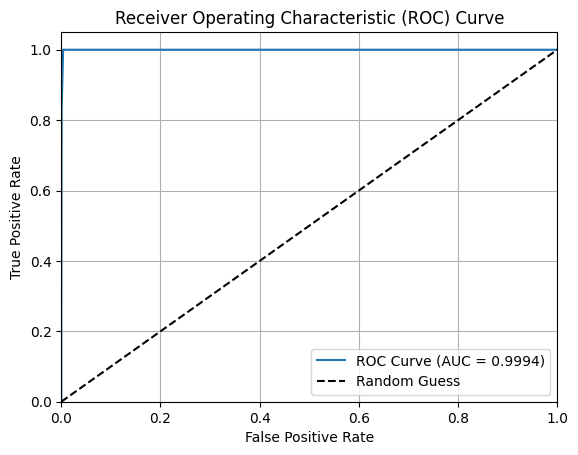

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()